November this year came in with a bang [where I live](https://www.google.com/maps/place/Edmonton,+AB/@53.5266805,-113.4927372,10z/data=!3m1!4b1!4m5!3m4!1s0x53a0224580deff23:0x411fa00c4af6155d!8m2!3d53.5460983!4d-113.4937266): the temperature outside is currently -20&deg;C, there is a pile of snow, and suddenly staying in and staying warm is a very important activity. At the same time, with [COP27](https://www.un.org/en/climatechange/cop27) taking place in Egypt, climate change is top of mind for everyone (Edmonton is [evaluating its net zero strategy](https://www.cbc.ca/news/canada/edmonton/shocked-and-disappointed-edmonton-climate-advisory-committee-decries-proposed-budget-1.6646702)) and I thought it would be worthwhile to look at one of the largest sources of household energy use in Canada: space heating. Space heating [accounts for 61.6% of household energy use](https://oee.nrcan.gc.ca/publications/statistics/trends/2017/residential.cfm), and in the province of Alberta that predominantly comes from burning natural gas. If we are going to meet our net zero goals as a municipality, we will need to address the carbon emissions that come from simply living here.

A commonly bandied about tool for reducing household carbon emissions is hydrogen blending, such as [this project in the Edmonton area](https://gas.atco.com/en-ca/community/projects/fort-saskatchewan-hydrogen-blending-project.html). The idea is to gradually increase the hydrogen content of the natural gas and, since hydrogen burns without producing any carbon dioxide, the carbon emissions will decline. This has the obvious advantage of using the existing gas distribution infrastructure and existing appliances (e.g. people's furnaces), thus avoiding costly retrofits.

But is this actually a useful thing to do? A common criticism of hydrogen is its low energy density: for a given flowrate you would expect to get ~1/3 the energy from pure hydrogen than from natural gas (assuming you are combusting it). *But* hydrogen is also incredibly light and, since flowrate is $\propto \frac{1}{\sqrt{\rho} }$, for the same pressure drop across a pipe you would expect a greater flowrate. So which is it? Does the energy content decrease, increase, or stay the same? Instead of just waving my hands and guessing, I thought it might be worthwhile to work through some simple calculations to get a sense of the scale of things. 

That said, it is rarely the case in engineering that decisions are clear cut. Blending hydrogen will have advantages and disadvantages, and whether the one out-weighs the other depends greatly on the particular location, its needs, infrastructure, and a host of other factors.

## Energy density

The obvious place to start, and where I have found people often end, is with the heating value. For convenience I am going to use [higher heating values](https://en.wikipedia.org/wiki/Heat_of_combustion#Higher_heating_value), given here per standard cubic meter. Where *standard* in this case means at 15&deg;C and 1atm.

In [1]:
#| output: false
using Unitful

# Standard State
R  = 8.31446261815324u"m^3*Pa/K/mol"
Tᵣ = 288.15u"K"
Pᵣ = 101325u"Pa"

# Hydrogen, from the GPSA handbook, 13th ed.
HHV_H2 = 12.109u"MJ/m^3"

# Natural Gas, typical
HHV_NG = 35.396u"MJ/m^3"

35.396 MJ m^-3

We can use a simple mixing rule to determine what the heating value would be with *x*% hydrogen by volume.

In [2]:
#| output: false
HHV(x) = x*HHV_H2 + (1-x)*HHV_NG

HHV (generic function with 1 method)

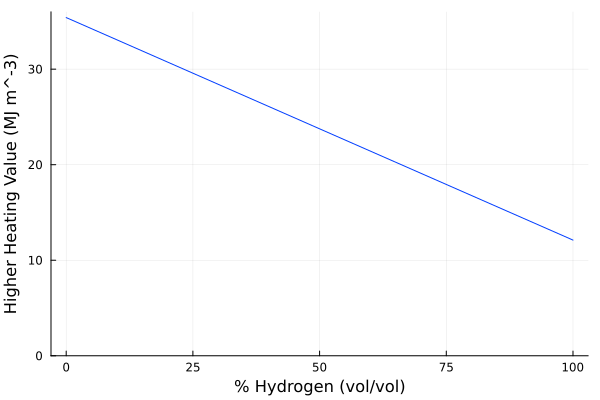

In [3]:
#| echo: false
#| label: fig-hhv
#| fig-cap: "Higher heating value of blended natural gas/hydrogen fuel gas as a function of hydrogen content, assuming an ideal gas and simple mixing rule."

using Plots

colors = palette(:seaborn_bright)

plot( [0,1].*100, [HHV(0),HHV(1)], ylim=(0,36), lab=false, color=colors[1],
      ylabel="Higher Heating Value", xlabel="% Hydrogen (vol/vol)")

Which clearly shows that increasing the hydrogen content decreases the overall heating value of the fuel. At 100% hydrogen the fuel gas has lost ~66% of it's heat content.

Suppose you are a customer whose natural gas was transitioned entirely to hydrogen, now you are receiving about a third of the energy per unit volume than you were before. Well the obvious thing to do would be to increase the volume that you use (by a factor of three) to make up the difference. This does raise the obvious question of *can you actually do that?* Superficially, it looks like you are asking to triple the demand on the current infrastructure.

## Energy per unit of pressure drop

The glaring omission with the previous analysis is that we know that flowrate, generally, is $\propto \frac{1}{\sqrt{\rho} }$, and natural gas is something like 9&times; denser than hydrogen. So, you would expect, for the same pressure drop in the same pipes, that you would get around 3&times; the flow of hydrogen.

Suppose we are only looking at the "last mile" of the distribution network, perhaps the pipe connecting your house to the main, reducing the problem to that of simple pipe flow. Assuming the flow is nearly isothermal, and an ideal gas, the mass velocity, *G*, of the fuel gas arriving at your house is given by:

$$ G = \sqrt{ \rho_1 P_1 } \sqrt{ \left(1 - \left( P_2 \over P_1 \right)^2 \right) \over { K - 2\log \left( P_2 \over P_1 \right)} } $$

Where 1 is the point just after the tee and 2 is the point just before your meter (e.g. a straight length of pipe). The volumetric flow rate, *Q*, at the upstream point 1, is then given by

$$ Q_1 = {\pi \over 4} D^2 {G \over \rho_1} $$

which, when corrected to the reference (standard) state is

$$ Q_s = Q_1 \cdot {v_{r} \over v_1} $$

Where *v* is the ideal gas molar volume (*RT*/*P*), a constant independent of the gas.

The heat rate, *q*, is simply the higher heating value times the volumetric flowrate (at standard state)

$$ q = HHV \cdot Q_s = HHV \cdot {\pi \over 4} D^2 \sqrt{P_1 \over \rho_1} \sqrt{ \left(1 - \left( P_2 \over P_1 \right)^2 \right) \over { K - 2\log \left( P_2 \over P_1 \right)} } \cdot {v_{r} \over v_1} $$

This looks like a lot however most of that is a constant, i.e. it is a function of the *system* and not the gas moving through it. 

$$ q = { HHV \over \sqrt{\rho_1} } \times \textrm{a constant} $$

So, assuming a constant pressure drop, along an identical pipe, with fully developed turbulent flow (i.e. *K* is constant) the ratio of heat delivered by hydrogen to that of natural gas is given by:

$$ { q_{H_2} \over q_{NG} } = { HHV_{H_2} \over HHV_{NG} } \sqrt{ \rho_{NG} \over \rho_{H_2} } = { HHV_{H_2} \over HHV_{NG} } \sqrt{ MW_{NG} \over MW_{H_2} }$$

In [4]:
# Hydrogen
MW_H2 = 2.016e-3u"kg/mol"

# Natural Gas
MW_NG = 19.5e-3u"kg/mol"

heat_ratio = (HHV_H2/HHV_NG)*√(MW_NG/MW_H2)

1.0639620426132184

So in total opposition to what we expected from merely looking at energy density we now expect, for the same system operating at the same pressures, to receive *slightly more* energy when transitioned over to pure hydrogen.

But what about the in-between, when hydrogen is blended into natural gas? Is it just a straight line connecting these two?

We can explore this more closely by first looking at how density, and thus volumetric flowrate, changes with the hydrogen content. I am assuming an ideal gas case and so the mixing rule is quite simple

$$ \rho = x_{H_2} \rho_{H_2} + x_{NG} \rho_{NG} $$

where, for an ideal gas

$$ \rho = MW {P \over {R T} } $$

giving

$$ \rho = {P \over {R T} } \left( x_{H_2} MW_{H_2} + x_{NG} MW_{NG} \right)$$

In [5]:
# ideal gas density
ρ(x, T, P) = (P/(R*T))*( x*MW_H2 + (1-x)*MW_NG );

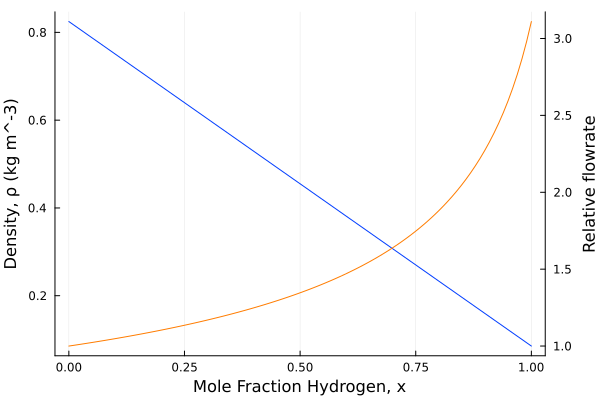

In [6]:
#| echo: false
#| label: fig-density
#| fig-cap: "Density and relative flowrate for blended natural gas/hydrogen fuel gas, assuming an ideal gas."
let

xs = range(0.0, 1.0, 100)
plot( xs, [ρ(x,Tᵣ,Pᵣ) for x in xs], ylabel="Density, ρ", 
      xlabel="Mole Fraction Hydrogen, x", lab=false, color=colors[1])
plot!(twinx(), xs, [ √(ρ(0,Tᵣ,Pᵣ)/ρ(x,Tᵣ,Pᵣ)) for x in xs], ylabel="Relative flowrate", 
      lab=false, color=colors[2])

end

So we have two competing effects: as the mole fraction increases the heating value of the gas decreases but at the same time the flowrate increases. We can explore this further by plotting the ratio of the heat rate with blended fuel gas to the heat rate with straight natural gas.

In [7]:
# heat rate for blended fuel gas relative to natural gas
q_ratio(x) = (HHV(x)/HHV_NG)*√(ρ(0,Tᵣ,Pᵣ)/ρ(x,Tᵣ,Pᵣ));

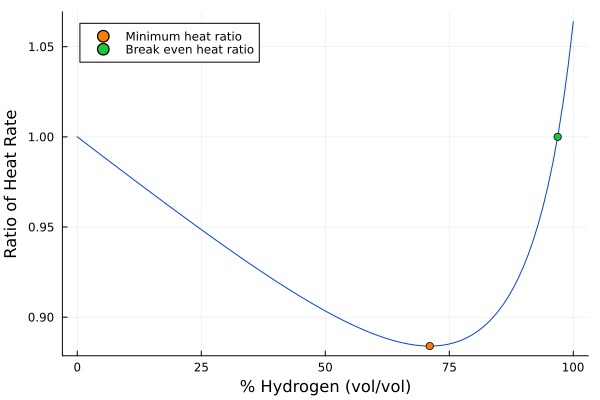

In [8]:
#| echo: false
#| label: fig-energy
#| fig-cap: "The amount of energy delivered, in higher heating value, for a blended natural gas/hydrogen fuel gas system at constant operating conditions, relative to natural gas"
let

xs = range(0.0, 1.0, 100)
plot( xs.*100, [q_ratio(x) for x in xs], lab=false, color=colors[1])
plot!([0.7106211503798253].*100, [0.8839840357969662], lab="Minimum heat ratio", 
      seriestype=:scatter, color=colors[2], legend=:topleft)
plot!([0.9684672945947692].*100, [1.0], lab="Break even heat ratio",
      seriestype=:scatter, color=colors[3])
plot!(ylabel="Ratio of Heat Rate", xlabel="% Hydrogen (vol/vol)", lab=false)

end

Initially the loss of heating value "wins out" and increasing the hydrogen content merely decreases the energy supplied at a given pressure. But once the stream is predominantly hydrogen, the lower density takes over and the heat rate increases.

The minimum ratio can be found by setting the derivative to zero

In [9]:
using ForwardDiff: derivative
using Roots: find_zero

∂q_ratio(x) = derivative(q_ratio,x)
xₘᵢₙ = find_zero(∂q_ratio,(0,1))

xₘᵢₙ, q_ratio(xₘᵢₙ)

(0.7106211503798253, 0.8839840357969662)

Initially, blending hydrogen decreases the overall energy delivered, bottoming out at ~12% less, when hydrogen makes up 71% of the fuel gas. While this is not the 66% decline predicted by a naive look at energy density, neither is it nothing.

Another important point is where the ratio becomes one: the concentration where the blended hydrogen fuel gas reattains the energy content of the original natural gas stream

In [10]:
xₑᵥₑₙ = find_zero( (x)-> q_ratio(x)-1, (xₘᵢₙ,1))

0.9684672945947692

The system doesn't recover the original energy supply until the hydrogen content is >96.8%, at which point a whole host of other concerns may become more relevant -- burning pure and nearly pure hydrogen comes with its own issues.

## Greenhouse gas emissions

The whole point of doing this is to decrease the carbon emissions associated with space heating (plus the other uses of household natural gas, but mostly space heating). So it is worth circling back to answer the question: does this actually do that? and by how much?

The dominant greenhouse gas associated with combustion is carbon dioxide, and the carbon dioxide emissions from combustion are fairly easy to calculate from stoichiometry, for a generic hydrocarbon the combustion equation is

$$ C_n H_m + \left( n + {m \over 4} \right) O_2 \rightarrow n CO_2 + {m \over 2} H_2 O $$

If we presume the natural gas is mostly methane and *n*≈1, then there is one mole of carbon dioxide produced per mole of natural gas delivered (assuming perfectly complete combustion). When combusting hydrogen there is no carbon dioxide produced, and so the moles of carbon dioxide produced from the combustion of a blended hydrogen fuel gas is

$$ \dot{n}_{CO_2} = \left( 1 - x_{H_2} \right) \dot{n}_{FG} $$

Where $\dot{n}$ is the molar flowrate. We don't actually know the molar flowrate of fuel gas, but we can calculate it from the ideal gas law and the volumetric flowrate at standard state *Q*<sub>s</sub>

$$ \dot{n}_{FG} = {P_r \over {R T_r} } Q_s $$

$$ \dot{n}_{CO_2} = \left( 1 - x_{H_2} \right) {P_r \over {R T_r} } Q_s $$

What we want is the *mass* flowrate of carbon dioxide, so simply multiply both sides by the molar weight

$$ \dot{m}_{CO_2} = \left( 1 - x_{H_2} \right) MW_{CO_2} {P_r \over {R T_r} } Q_s \\ = \left( 1 - x_{H_2} \right) \rho_{CO_2,r} Q_s $$

If we assume that the users of fuel gas are using a fixed amount of energy, regardless of the actual flowrate, then what we want is the carbon *intensity* of the fuel: how much carbon dioxide is emitted *per Megajoule* of heat generated?

$$ E = \frac{\dot{m}_{CO_2} }{q} = { {\left( 1 - x_{H_2} \right) \rho_{CO_2,r} Q_s} \over {HHV(x) Q_s} } = { { \left( 1 - x_{H_2} \right) \rho_{CO_2,r} } \over {HHV(x)} }$$


In [11]:
#| output: false
# Carbon Dioxide
MW_CO2 = 44.009e-3u"kg/mol"
ρ_CO2 = MW_CO2*Pᵣ/(R*Tᵣ)

E(x) = (1-x)*ρ_CO2/HHV(x)

E (generic function with 1 method)

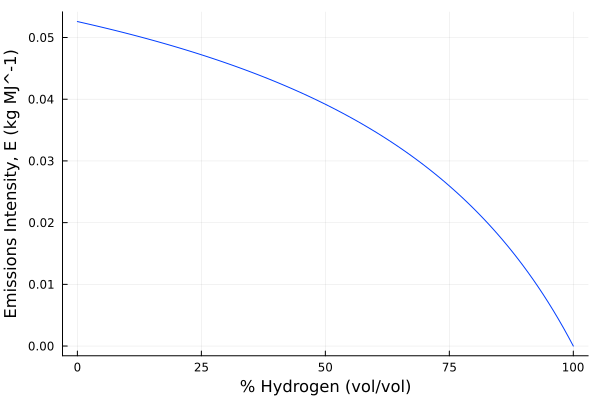

In [12]:
#| echo: false
#| label: fig-co2
#| fig-cap: "The carbon dioxide emissions intensity for a blended natural gas/hydrogen fuel gas, over a range of hydrogen content."
let

xs = range(0.0, 1.0, 100)
plot( xs.*100, [E(x) for x in xs], lab=false, color=colors[1],
      ylabel="Emissions Intensity, E", xlabel="% Hydrogen (vol/vol)")

end

So there are emissions reductions but *at a cost*, beyond whatever method is used to generate the hydrogen in the first place. The system must be operated at greater pressures to supply the same amount of energy, which itself takes some energy, at least until the hydrogen exceeds 96.8%. At that high level the system seems like an easy win: it takes *less* pressure to supply the same amount of energy and the emissions intensity is a ~8.7% that of natural gas (a ~91% reduction)

In [13]:
E(xₑᵥₑₙ)/E(0)

0.08690379085511468

There are a few caveats with this: for one carbon dioxide is not the only significant greenhouse gas that comes from combustion, nitrous oxide is also produced and has a global warming potential ~300&times; that of carbon dioxide. Unlike carbon dioxide, [nitrous oxide](https://en.wikipedia.org/wiki/Nitrous_oxide#Atmospheric_occurrence) is producded when hydrogen is combusted with air because, like many other nitrogen oxides, it is generated from the high temperature reaction of the nitrogen and oxygen from the air. So burning pure hydrogen is only net zero for very particular definitions of zero, it is *not* net zero greenhouse gas emissions though it is net zero carbon emissions.

## Material concerns

So far the analysis has completely ignored the *material* issues that hydrogen brings. At high temperatures (such as, say, inside a furnace that is burning hydrogen) [high temperature hydrogen attack](https://en.wikipedia.org/wiki/High_temperature_hydrogen_attack) is a real concern and using hydrogen as a fuel gas would eventually destroy most burners that were designed for use with natural gas. Similarly [hydrogen embrittlement](https://en.wikipedia.org/wiki/Hydrogen_embrittlement) would be a concern for the entire system, wherever steel is used. Neither of these are insurmountable but they would require extensive retrofitting with different materials and special alloys. This dampens a lot of the advantages of hydrogen blending, namely being able to use the existing infrastructure.

To skip over the details (I'm not a materials engineer), I think it is fair to say that the mechanical integrity of the system is strongly dependent on the hydrogen content and it likely will be a limiting factor in any hydrogen blending project.

## Conclusions

At the level of "back of the envelope" calculations like I have done above, it is fairly clear that blending hydrogen into the utility natural gas system is not a panacea, but then neither is it completely infeasible. I think there are several other factors that need to be considered when evaluating the possible role of hydrogen blending in the future energy mix:

+ *Availability of hydrogen* - in areas like Edmonton, there are already industrial suppliers of hydrogen (and large industrial consumers), with a roadmap to both expand that capacity and bring it to net zero emissions. Tying into that existing network significantly lowers the barrier for a blending project and can realize *real emissions reductions* now.
+ *Feasibility of alternatives* - it seems to be accepted wisdom that, at least for now, air source heat pumps are not very effective below -20&deg;C. It is entirely possible that, while retrofitting to add heat pumps to homes would be hugely effective for most of the year, households in Edmonton would still require some additional source of space heating for those extremely cold days. Not only are -20&deg;C days fairly normal in the winter, it is not at all uncommon to exceed -30&deg;C and periodically it gets to -40&deg;C. Hydrogen blending could be part of that energy future, as people with heat pumps keep their furnaces around.
+ *Existing housing stock/pace of retrofits* - it may be the case that, after performing a full life cycle analysis, heat pumps + resistive heating is the better technology. But that may fail to acknowledge the greater metropolitan area of 1.4M people that is Edmonton who, almost universally, live in buildings that do not have heat pumps and resistive heating, and instead rely on natural gas fired heaters (e.g. furnaces, boilers). With the majority of household energy use being space heating, hydrogen blending may have a role in realizing significant emissions reductions while the existing housing stock is transitioned over.

Personally I think hydrogen's role in the future is over-hyped. A lot of people working in the fossil fuel space have pinned their industry's future on hydrogen, which comes with a certain amount of motivated reasoning. Also hydrogen is appealing as it looks like the easy solution: swap the burning of one fuel for the burning of another, and we don't have to make sweeping and systemic change, except that hydrogen brings its own host of issues (low energy density, material incompatibility). I think the answer will turn out not to be one silver bullet, like hydrogen, but an entire ecosystem of different technologies, often hyper specific to different locations, and what will connect them all will be the electrification of everything. That said, we have a vast, globe spanning, infrastructure and centuries of know-how in burning things and that gives hydrogen a big leg-up as a transitional solution.

## An example system

I thought I would end with a basic pipe flow example, if you wanted to look at specific numbers this is how you might start that. This is also an example of the life changing magic of solving problems with code: once you have solved them once you never have to solve them again. Since I have frequently worked out pipe flow problems with julia, I can throw together a *more detailed than is at all necessary* model through the magic of copying and pasting.

### Mixture viscosity

We've already worked out the mixture density and heating value, and the next most important material property is viscosity. I don't have a curve for natural gas, so I am just going to use methane as a proxy. I am already treating natural gas like a homogeneous substance, so this is simply an extension of that.

In [14]:
#| output: false
using UnitfulCorrelations

# Hydrogen - from Perry's, 8th ed.
μ_H2(T) = (1.797e-7*T^0.685)/(1-0.59/T+140/(T^2));
@ucorrel μ_H2 u"K" u"Pa*s"

# Methane (Natural Gas) - from Perry's, 8th ed. 
μ_NG(T) = (5.2546e-7*T^0.59006)/(1+105.67/T);
@ucorrel μ_NG u"K" u"Pa*s"

μ_NG (generic function with 2 methods)

Where I have used [a macro that I wrote previously](https://github.com/aefarrell/UnitfulCorrelations.jl) to turn correlations into correlations *with units*.

At standard conditions the viscosity of hydrogen and that of natural gas (methane) are not too different, so we can get away with using a simple method for estimating the viscosity of the overall mixture.

In [15]:
μ_H2(Tᵣ)/μ_NG(Tᵣ)

0.8004989026814741

I happen to already have Wilke's method for a binary mixture worked out, I just need to swap in what the two components are. A more fulsome analysis would have a complete composition of natural gas (broken down into methane, ethane, propane, etc.) in which case the generalized Wilke's method could be used as well.

In [16]:
# mixture viscosity using Wilke method
# from *The Properties of Gases and Liquids* 5th ed.
function μ(x,T)
    μ₁ = μ_H2(T)
    M₁ = MW_H2
    y₁ = x
    
    μ₂ = μ_NG(T)
    M₂ = MW_NG
    y₂ = 1-x
    
    ϕ₁₂ = ((1+√((μ₁/μ₂)*√(M₂/M₁)))^2)/√(8*(1+(M₁/M₂)))
    ϕ₂₁ = ϕ₁₂*(μ₂/μ₁)*(M₁/M₂)
    
    μ = (y₁*μ₁/(y₁+y₂*ϕ₁₂)) + (y₂*μ₂/(y₂+y₁*ϕ₂₁))
    return μ
end;

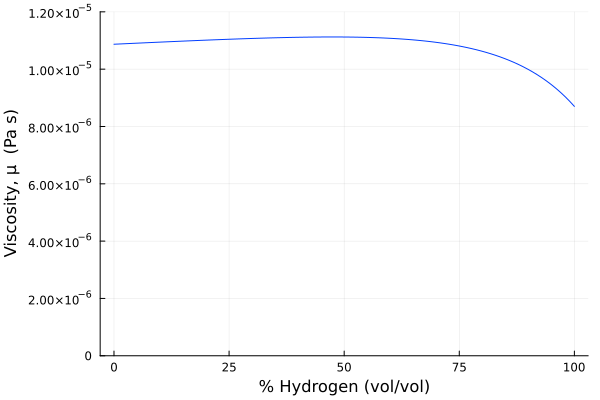

In [17]:
#| echo: false
#| label: fig-viscosity
#| fig-cap: "The viscosity of blended natural gas/hydrogen for a range of hydrogen content. For a wide range the viscosity is nearly constant."
let

xs = range(0.0, 1.0, 100)
plot( xs.*100, [μ(x, Tᵣ) for x in xs], lab=false, color=colors[1],
      ylabel="Viscosity, μ ", xlabel="% Hydrogen (vol/vol)", ylim=(0,1.2e-5))

end

### Pipe dimensions and friction

For the sake of having something to calculate I am just assuming a 20m length of 2in steel pipe. But you could put in really anything here.

In [18]:
#| output: false
# Pipe dimensions
L = 20u"m"      # length
D = 52.5u"mm"   # diameter
ϵ = 0.0457u"mm" # roughness

A = 0.25*π*D^2  # cross-sectional area
l = L/D         # relative length
κ = ϵ/D         # relative roughness

0.0008704761904761904

The Reynold's number is simply a function of the mass velocity, *G*, the pipe diameter, *D*, and the mixture viscosity *&mu;*

In [19]:
# Reynold's number
Re(x,T,G) = G*D/μ(x,T);

I am using my favourite correlation for the Darcy friction factor, *f*,

In [20]:
# Churchill correlation, from Perry's
function churchill(Re)
    A = (2.457 * log(1/((7/Re)^0.9 + 0.27*κ)))^16
    B = (37530/Re)^16
    return 8*((8/Re)^12 + 1/(A+B)^(3/2))^(1/12)
end;

Since this is just a straight length of pipe, the K factor is simply *fL*/*D*, defaulting back to the Nikuradse rough pipe law for fully developed turbulent flow (i.e. very high Reynold's numbers)

In [21]:
#| output: false
Kf() = l/(2*log10(3.7/κ))^2 # Nikuradse
Kf(Re) = l*churchill(Re)    # Churchill

Kf (generic function with 2 methods)

### Volumetric flowrate

The volumetric flowrate for an isothermal ideal gas is simply the mass velocity, *G*, multiplied by the cross sectional area and divided by the density *GA*/*&rho;*. It is very easy to modify some code I had previously written to solve for the volumetric flowrate.

In [22]:
#| output: false
# Isothermal ideal gas pipeflow
function Q₁(x, T₁, P₁, P₂, K::Number)
    ρ₁ = ρ(x, T₁, P₁)
    v̄₁ = 1/ρ₁
    q  = P₂/P₁
    Q₁ = A*√((v̄₁*P₁*(1-q^2))/(K-2*log(q)))
    return upreferred(Q₁)
end

function Q₁(x, T₁, P₁, P₂, K::Function)
    # Initialize Parameters
    ρ₁ = ρ(x, T₁, P₁)
    q = P₂/P₁
    
    # Initial Guesses
    Q₀ = Q₁(x, T₁, P₁, P₂, K())
    G₀ = Q₀*ρ₁/A

    # Numerically solve for G
    obj(G) = (K(Re(x,T₁,G))- 2*log(q))*(G^2) - ρ₁*P₁*(1-q^2)
    G = find_zero(obj, G₀)
    
    return upreferred(G*A/ρ₁)
end

Q₁ (generic function with 2 methods)

This uses julia's multiple dispatch to handle two cases: for large Reynold's numbers where *K* is a constant, and for cases where K is a function of the Reynold's number (and thus the volumetric flowrate).

The volumetric flowrate at standard state is then the flowrate from above, corrected to the reference pressure and temperature[^unitful]

[^unitful]: I have been using `upreferred` to force Unitful to cancel out and simplify units.

In [23]:
Qₛ(x, T₁, P₁, P₂) = upreferred((P₁/Pᵣ)*(Tᵣ/T₁)*Q₁(x, T₁, P₁, P₂, Kf))

Qₛ (generic function with 1 method)

### Heat rate

The heat rate is then the heating value, already worked out, times the volumetric flowrate at standard state

In [24]:
q(x, T₁, P₁, P₂) = HHV(x)*Qₛ(x, T₁, P₁, P₂)

q (generic function with 1 method)

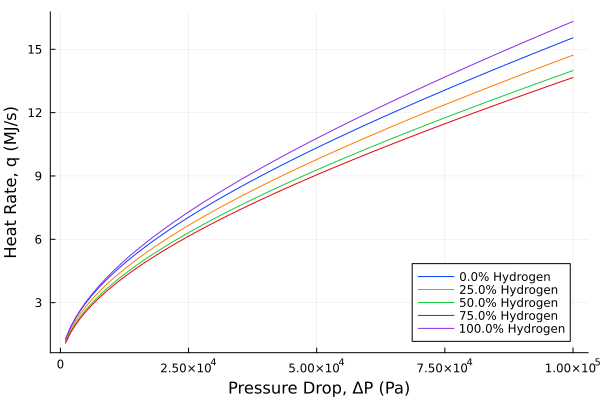

In [25]:
#| echo: false
#| label: fig-energy-pv
#| fig-cap: "The energy supplied by the example fuel gas delivery system for a range of pressure drops. Pure natural gas and pure hydrogen deliver nearly the same energy for the same pressure drop."
let

Δps = range(1.0,100.0,100).*1e3u"Pa"
ps = Pᵣ.+Δps
xs = range(0.0,1.0,5)

fig = plot(palette=colors)

for x in xs
    qs = [ q(x, Tᵣ, p, Pᵣ) for p in ps ]
    plot!(fig, Δps, qs, lab="$(round(x*100))% Hydrogen")
end

plot!(fig, ylabel="Heat Rate, q (MJ/s)", xlabel="Pressure Drop, ΔP (Pa)", legend=:bottomright)

end

We see the same ordering that we expect, given the previous analysis, namely that the 0% and 100% cases are pretty close to each other, followed by the in-between hydrogen contents.

Another way of looking at this is to pick a required heat rate and look at the pressure drop as a function of hydrogen content.

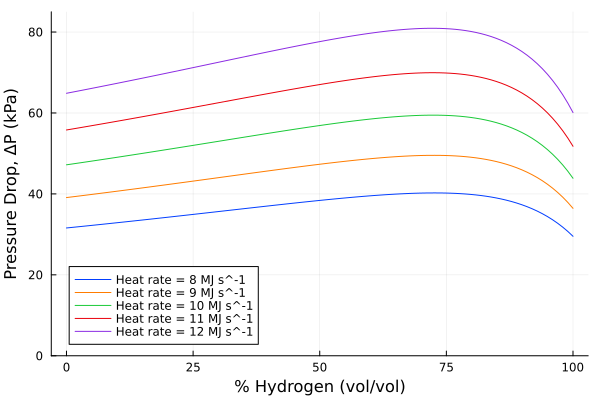

In [26]:
#| echo: false
#| label: fig-pressure-drop
#| fig-cap: "The pressure drop required to deliver a fixed heat rate for blended natural gas/hydrogen fuel gas in the example system."

let
obj(ΔP, x, set_point) = ustrip(q(x, Tᵣ, Pᵣ+(ΔP*1u"Pa"), Pᵣ) - set_point)
xs = range(0.0,1.0,100)
    
fig = plot(palette=colors)

for set_point in [8, 9, 10, 11, 12].*1u"MJ/s"
    Δps = [ find_zero((p)->obj(p,x,set_point), 5e4) for x in xs ]
    plot!(fig, xs.*100, Δps.*1e-3, lab="Heat rate = $set_point")
end    
    
plot!(fig, ylabel="Pressure Drop, ΔP (kPa)", xlabel="% Hydrogen (vol/vol)",
      ylim=(0,85), legend=:bottomleft)
end

All of this has been done assuming the ideal gas case. The next logical step is to start incorporating non-ideal gas models, say a cubic equation of state, and so on.

## References
::: {#refs}
:::